<a href="https://colab.research.google.com/github/kairamilanifitria/NLP-Projects/blob/main/Project%202%20Text%20Summarization/Project2_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Data Overview

1.   **Shape of the dataset:** Check how many records there are in each file (train, test, dev).
2.   **Null/missing values:** Verify if any columns contain null values.
3.   **Data types:** Ensure that columns like id, url, clean_article, clean_summary, and extractive_summary are of the expected data types.

In [1]:
import pandas as pd

# Load the dataset
train_df = pd.read_csv('/content/drive/MyDrive/Bootcamp AI/Dataset/Task2 : Text Summarization/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Bootcamp AI/Dataset/Task2 : Text Summarization/test.csv')
dev_df = pd.read_csv('/content/drive/MyDrive/Bootcamp AI/Dataset/Task2 : Text Summarization/dev.csv')

# Basic overview
print(train_df.shape)
print(train_df.info())
print(train_df.isnull().sum())

(193883, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193883 entries, 0 to 193882
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   id                  193883 non-null  int64 
 1   url                 193883 non-null  object
 2   clean_article       193883 non-null  object
 3   clean_summary       193883 non-null  object
 4   extractive_summary  193883 non-null  object
dtypes: int64(1), object(4)
memory usage: 7.4+ MB
None
id                    0
url                   0
clean_article         0
clean_summary         0
extractive_summary    0
dtype: int64


# Text Length Analysis



1.   **Objective**: Understand the length of articles and summaries to check for patterns.
2.   Calculate the number of words and sentences in the `clean_article` and `clean_summary`.
3. Visualize the distribution of text lengths using histograms or boxplots.



***analysis :***
1.   Are summaries much shorter than articles (as expected)?
2.   How do article lengths vary? Are there any extreme outliers?


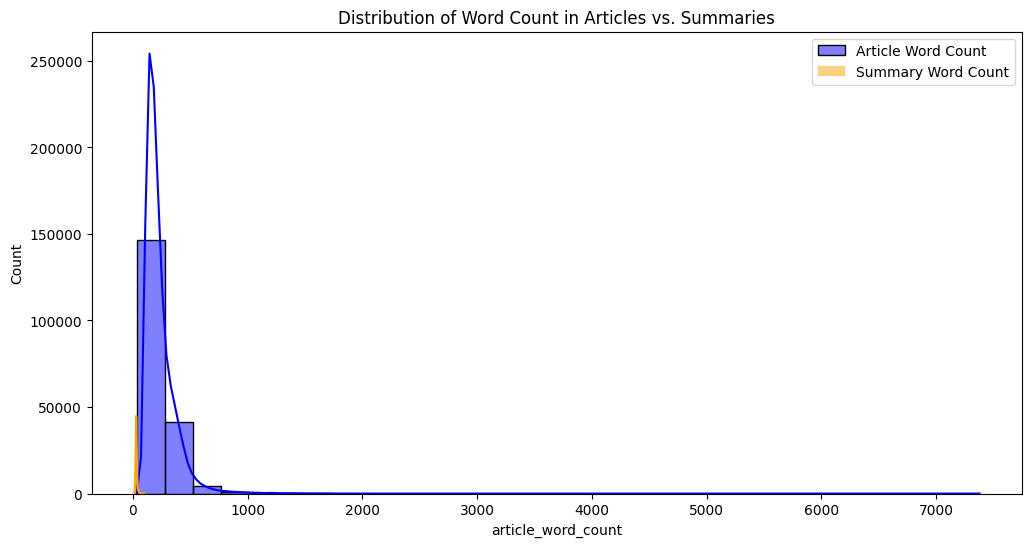

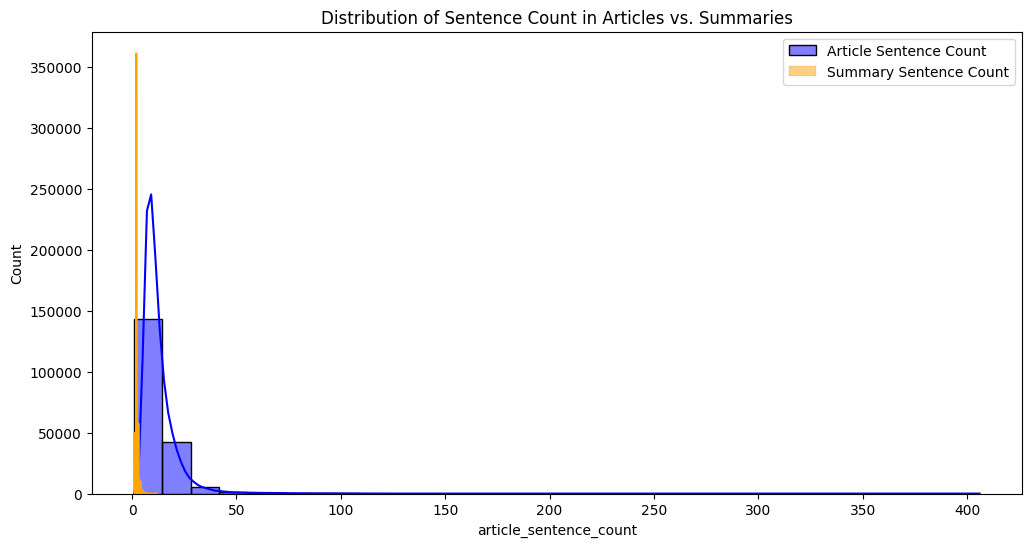

In [ ]:
# Calculate word and sentence counts for clean_article and clean_summary
train_df['article_word_count'] = train_df['clean_article'].apply(lambda x: sum(len(sent) for sent in eval(x)))
train_df['summary_word_count'] = train_df['clean_summary'].apply(lambda x: sum(len(sent) for sent in eval(x)))
train_df['article_sentence_count'] = train_df['clean_article'].apply(lambda x: len(eval(x)))
train_df['summary_sentence_count'] = train_df['clean_summary'].apply(lambda x: len(eval(x)))

# Visualize distributions
import seaborn as sns
import matplotlib.pyplot as plt

# Word count distributions
plt.figure(figsize=(12,6))
sns.histplot(train_df['article_word_count'], bins=30, color='blue', label='Article Word Count', kde=True)
sns.histplot(train_df['summary_word_count'], bins=30, color='orange', label='Summary Word Count', kde=True)
plt.legend()
plt.title('Distribution of Word Count in Articles vs. Summaries')
plt.show()

# Sentence count distributions
plt.figure(figsize=(12,6))
sns.histplot(train_df['article_sentence_count'], bins=30, color='blue', label='Article Sentence Count', kde=True)
sns.histplot(train_df['summary_sentence_count'], bins=30, color='orange', label='Summary Sentence Count', kde=True)
plt.legend()
plt.title('Distribution of Sentence Count in Articles vs. Summaries')
plt.show()

# Extractive Summary Analysis

1.   **Objective**: Understand how much of the article is covered in the extractive summary
2.   **Key actions**: For each article, calculate the percentage of sentences that are included in the `extractive_summary`.
3. Visualize the distribution of these percentages.


Insights:
*   How many sentences, on average, are included in the extractive summary?
*   Are the extractive summaries mostly short, or do they cover a large portion of the article?

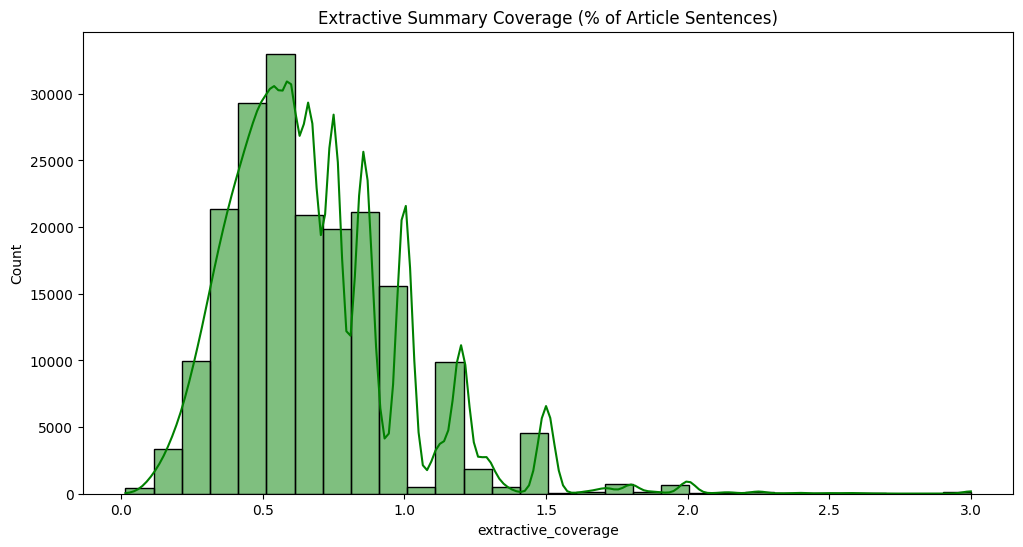

In [ ]:
# Extractive summary coverage
train_df['extractive_coverage'] = train_df.apply(
    lambda row: len(row['extractive_summary']) / len(eval(row['clean_article'])), axis=1
)

# Visualize coverage
plt.figure(figsize=(12,6))
sns.histplot(train_df['extractive_coverage'], bins=30, color='green', kde=True)
plt.title('Extractive Summary Coverage (% of Article Sentences)')
plt.show()


# N-gram and Word Frequency Analysis

1.   **Objective**: Identify the most common words and phrases used in both the articles and the summaries.
2.   **Key actions**:Perform word frequency analysis and plot the most common unigrams, bigrams, or trigrams in `clean_article` and `clean_summary`.

Insights:
*   Are the same key terms or phrases frequently appearing in both articles and summaries?
*   Are there any domain-specific terms or phrases?

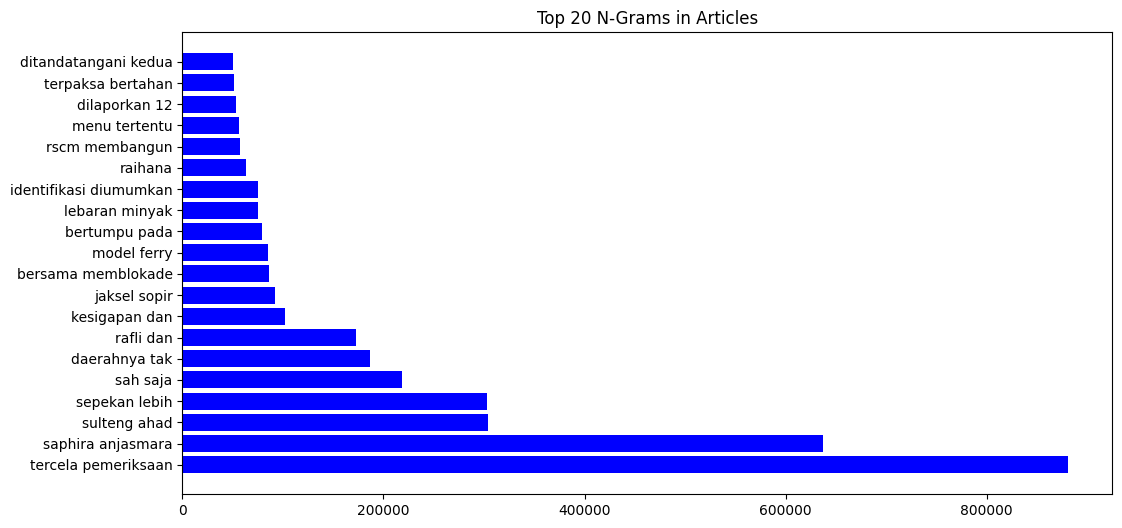

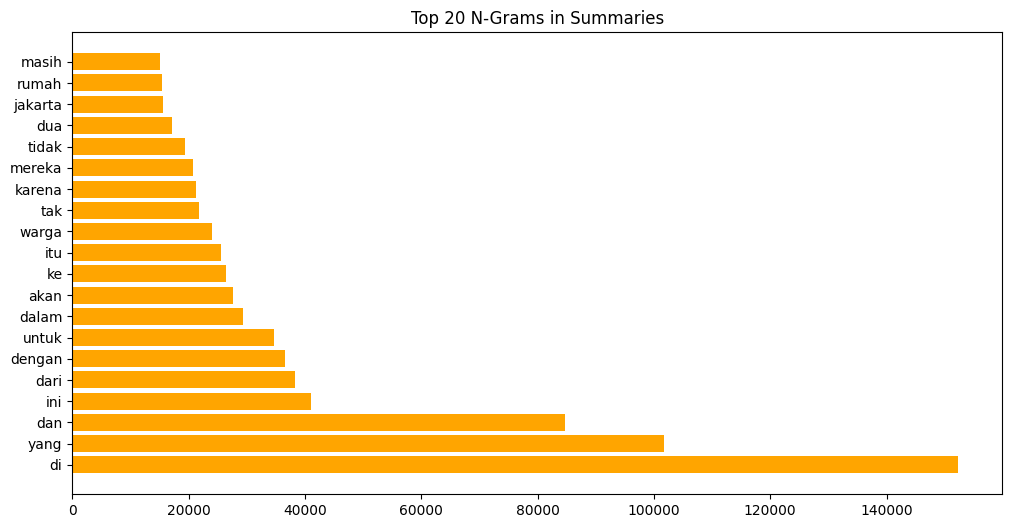

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# Flatten the list of tokens for the entire dataset
article_corpus = [' '.join([' '.join(sent) for sent in eval(article)]) for article in train_df['clean_article']]
summary_corpus = [' '.join([' '.join(sent) for sent in eval(summary)]) for summary in train_df['clean_summary']]

# Vectorize
vectorizer = CountVectorizer(ngram_range=(1,2), stop_words=None)  # You can add stopwords if needed
article_ngrams = vectorizer.fit_transform(article_corpus)
summary_ngrams = vectorizer.fit_transform(summary_corpus)

# Get the top n most frequent n-grams
top_n = 20
article_freqs = Counter(dict(zip(vectorizer.get_feature_names_out(), article_ngrams.sum(axis=0).A1))).most_common(top_n)
summary_freqs = Counter(dict(zip(vectorizer.get_feature_names_out(), summary_ngrams.sum(axis=0).A1))).most_common(top_n)

# Plot the results
plt.figure(figsize=(12,6))
plt.barh([x[0] for x in article_freqs], [x[1] for x in article_freqs], color='blue')
plt.title('Top 20 N-Grams in Articles')
plt.show()

plt.figure(figsize=(12,6))
plt.barh([x[0] for x in summary_freqs], [x[1] for x in summary_freqs], color='orange')
plt.title('Top 20 N-Grams in Summaries')
plt.show()


# Comparing Extractive and Abstractive Summaries

1.   **Objective**: Evaluate the differences between extractive and abstractive summaries.
2.   **Key actions**: Check how similar the `clean_summar`y (abstractive) and `extractive_summary` are by comparing the number of overlapping sentences.
3. Compute an overlap score by checking how many sentences or words in the extractive summary are also present in the abstractive summary.


Insights:
*   Are the abstractive summaries significantly different from the extractive ones?
*   Does the overlap between the two indicate how the abstractive summary might have been generated?

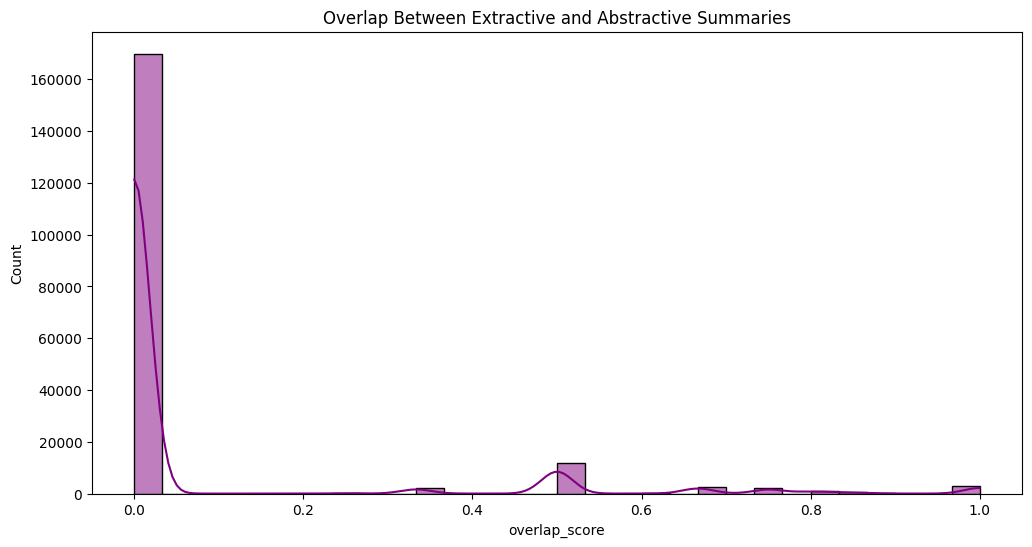

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import ast

def sentence_overlap(article, abstractive, extractive_indices):
    article_sents = eval(article)
    abstractive_sents = eval(abstractive)
    # Ensure extractive_indices contains integers
    # Safely evaluate the string representation of the list
    try:
        extractive_indices = ast.literal_eval(extractive_indices)
    except (SyntaxError, ValueError):
        # Handle cases where the string is not a valid list
        extractive_indices = []  # or any other appropriate default

    extractive_indices = [int(i) for i in extractive_indices]
    extractive_sents = [article_sents[i] for i in extractive_indices]
    # Count overlap
    overlap_count = len(set([' '.join(sent) for sent in extractive_sents]) & set([' '.join(sent) for sent in abstractive_sents]))
    return overlap_count / len(abstractive_sents)

train_df['overlap_score'] = train_df.apply(lambda row: sentence_overlap(row['clean_article'], row['clean_summary'], row['extractive_summary']), axis=1)

# Visualize overlap score
plt.figure(figsize=(12,6))
sns.histplot(train_df['overlap_score'], bins=30, color='purple', kde=True)
plt.title('Overlap Between Extractive and Abstractive Summaries')
plt.show()

# EDA Summary and Actionable Insights

After performing these steps, summarize key observations and possible next steps:
*   Are there outliers in text lengths?
*   Do the extractive summaries tend to cover the key points in the article, or do they miss significant parts?
*   How similar or different are the extractive and abstractive summaries?


 1. the extractive summaries have low overlap with the abstractive ones, suggesting that while they may cover some key points, they likely miss more nuanced or synthesized content. Extractive summaries can struggle with cohesively capturing the overall meaning, especially in cases where key points are implicit or scattered throughout the text.
 2. The similarity between extractive and abstractive summaries, as shown in the overlap plot, is quite low. The concentration of overlap scores near zero suggests that extractive and abstractive summaries are mostly different. Abstractive summaries tend to paraphrase or reword the content, often reorganizing or compressing the information to create more fluid and coherent summaries.

# Content Similarity between Article and Summary

We'll calculate the cosine similarity between the `"clean_article"` and `"clean_summary"` to measure how closely the summaries align with the original content.

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity(article, summary):
    vectorizer = TfidfVectorizer().fit_transform([article, summary])
    vectors = vectorizer.toarray()
    cosine_sim = cosine_similarity([vectors[0]], [vectors[1]])
    return cosine_sim[0][0]

# Apply to dataset
train_df['similarity'] = train_df.apply(lambda row: calculate_similarity(row['clean_article'], row['clean_summary']), axis=1)

# Inspect similarity scores
train_df[['clean_article', 'clean_summary', 'similarity']].head()

,clean_article,clean_summary,similarity
0,"[['Liputan6', '.', 'com', ',', 'Jakarta', ':',...","[['Artis', 'muda', 'Haykal', 'dan', 'Putri', '...",0.156472
1,"[['Striker', 'Timnas', 'Inggris', 'yang', 'ber...","[['Pertandingan', 'melawan', 'Manchester', 'Ci...",0.265350
2,"[['Liputan6', '.', 'com', ',', 'Jakarta', ':',...","[['Harga', 'bahan', 'pokok', 'seperti', 'minya...",0.403696
3,"[['Liputan6', ',', 'com', ',', 'Kupang', ':', ...","[['Evakuasi', 'warga', 'negara', 'Indonesia', ...",0.325798
4,"[['Liputan6', '.', 'com', ',', 'Lembata', ':',...","[['Status', 'Gunung', 'Batutara', 'ditetapkan'...",0.491875


Maximum Similarity Score: 1.0000000000000009


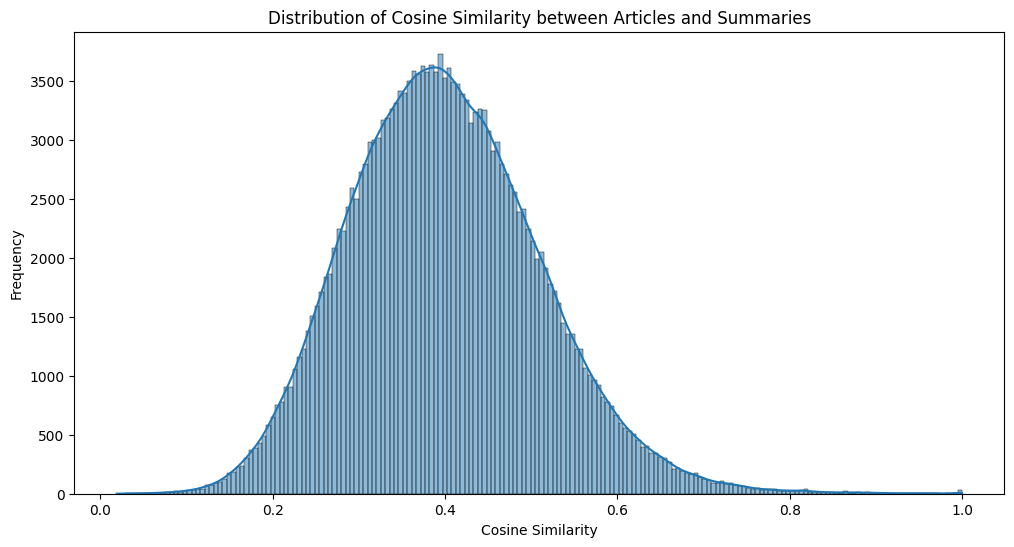

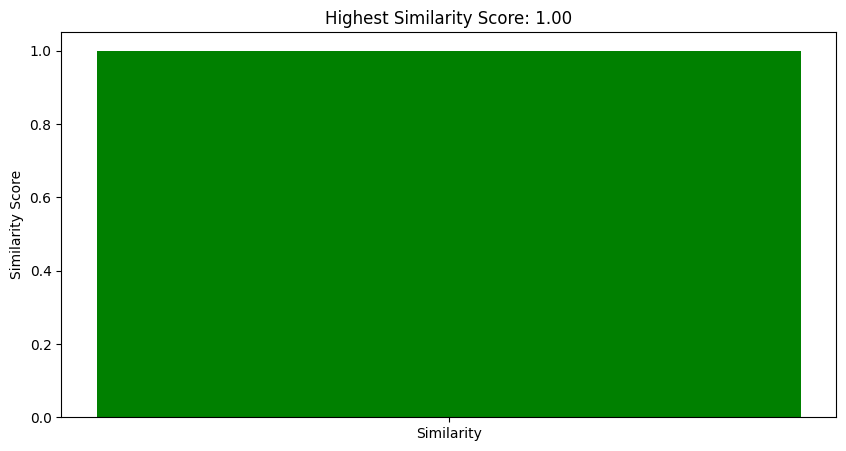

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Find the highest similarity score
max_similarity = train_df['similarity'].max()
print(f"Maximum Similarity Score: {max_similarity}")

# Visualize the distribution of similarity scores
plt.figure(figsize=(12, 6))
sns.histplot(train_df['similarity'], kde=True)
plt.title('Distribution of Cosine Similarity between Articles and Summaries')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

# You can also visualize the highest similarity score using a scatter plot or a bar chart
# for example, to show the article-summary pair with the highest similarity:

# Find the index of the row with the highest similarity
highest_similarity_index = train_df['similarity'].idxmax()

# Get the corresponding row
highest_similarity_row = train_df.loc[highest_similarity_index]

# Visualize the highest similarity
plt.figure(figsize=(10, 5))
plt.bar(['Similarity'], [highest_similarity_row['similarity']], color='green')
plt.title(f'Highest Similarity Score: {highest_similarity_row["similarity"]:.2f}')
plt.ylabel('Similarity Score')
plt.show()

# Redundancy in Articles

repeated phrases or sentences in the articles.

In [5]:
from collections import Counter

def find_redundancy(text, n_gram_size=3):
    words = text.split()
    n_grams = [' '.join(words[i:i+n_gram_size]) for i in range(len(words)-n_gram_size+1)]
    n_gram_counter = Counter(n_grams)
    redundant_phrases = {phrase: count for phrase, count in n_gram_counter.items() if count > 1}
    return redundant_phrases

# Apply to dataset
train_df['redundancy'] = train_df['clean_article'].apply(find_redundancy)

# Check redundancy results
train_df[['clean_article', 'redundancy']].head()


,clean_article,redundancy
0,"[['Liputan6', '.', 'com', ',', 'Jakarta', ':',...","{'',', '""', 'ucap',': 2}"
1,"[['Striker', 'Timnas', 'Inggris', 'yang', 'ber...","{''.'], ['Meski', 'demikian',': 2, '['Meski', ..."
2,"[['Liputan6', '.', 'com', ',', 'Jakarta', ':',...","{''.', '000', 'per',': 2, ''000', 'per', 'kilo..."
3,"[['Liputan6', ',', 'com', ',', 'Kupang', ':', ...","{''dari', 'Timor', 'Leste',': 2, ''dari', 'wil..."
4,"[['Liputan6', '.', 'com', ',', 'Lembata', ':',...",{}


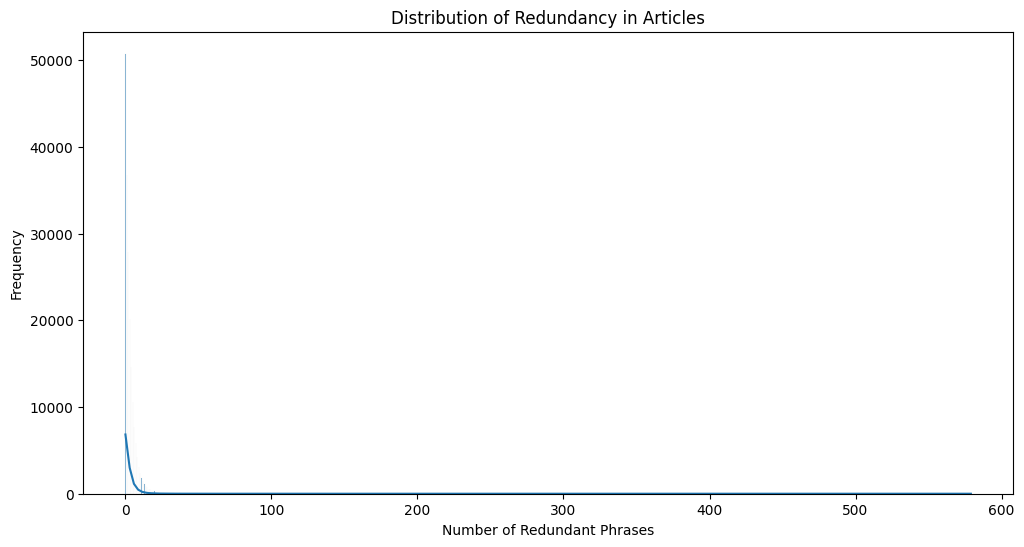

In [6]:


# Count the number of redundant phrases in each article
train_df['redundancy_count'] = train_df['redundancy'].apply(len)

# Visualize the distribution of redundancy counts
plt.figure(figsize=(12, 6))
sns.histplot(train_df['redundancy_count'], kde=True)
plt.title('Distribution of Redundancy in Articles')
plt.xlabel('Number of Redundant Phrases')
plt.ylabel('Frequency')
plt.show()


# Distribution of Extractive vs Abstractive Summaries

compare the lengths of extractive and abstractive summaries to the original article.

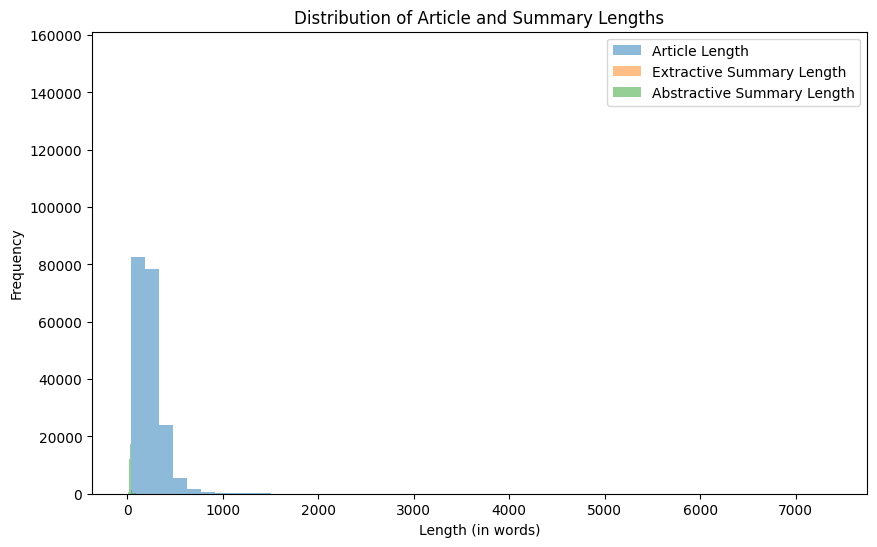

In [7]:
import matplotlib.pyplot as plt

# Calculate lengths
train_df['article_length'] = train_df['clean_article'].apply(lambda x: len(x.split()))
train_df['extractive_summary_length'] = train_df['extractive_summary'].apply(lambda x: len(x.split()))
train_df['abstractive_summary_length'] = train_df['clean_summary'].apply(lambda x: len(x.split()))

# Plot the distributions
plt.figure(figsize=(10,6))
plt.hist(train_df['article_length'], bins=50, alpha=0.5, label='Article Length')
plt.hist(train_df['extractive_summary_length'], bins=50, alpha=0.5, label='Extractive Summary Length')
plt.hist(train_df['abstractive_summary_length'], bins=50, alpha=0.5, label='Abstractive Summary Length')
plt.legend(loc='upper right')
plt.title('Distribution of Article and Summary Lengths')
plt.xlabel('Length (in words)')
plt.ylabel('Frequency')
plt.show()


# Summarization Compression Ratio

compute the ratio of article length to summary length for both extractive and abstractive summaries.

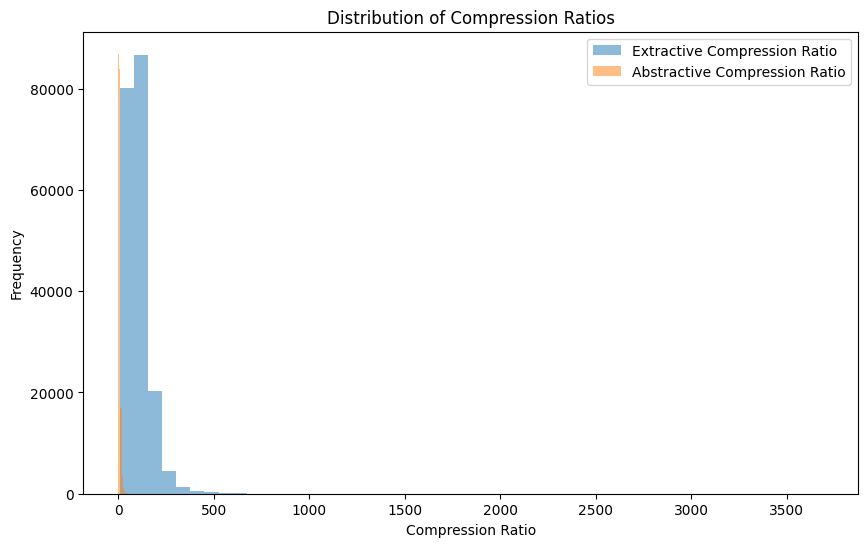

In [8]:
# Calculate compression ratios
train_df['extractive_compression_ratio'] = train_df['article_length'] / train_df['extractive_summary_length']
train_df['abstractive_compression_ratio'] = train_df['article_length'] / train_df['abstractive_summary_length']

# Check results
train_df[['article_length', 'extractive_summary_length', 'abstractive_summary_length',
    'extractive_compression_ratio', 'abstractive_compression_ratio']].head()

# Plot the compression ratios
plt.figure(figsize=(10,6))
plt.hist(train_df['extractive_compression_ratio'], bins=50, alpha=0.5, label='Extractive Compression Ratio')
plt.hist(train_df['abstractive_compression_ratio'], bins=50, alpha=0.5, label='Abstractive Compression Ratio')
plt.legend(loc='upper right')
plt.title('Distribution of Compression Ratios')
plt.xlabel('Compression Ratio')
plt.ylabel('Frequency')
plt.show()
